## 2.3　勾配ブースティング法の`sklearn`によるデモ

### A. 勾配ブースティング決定木回帰モデル

ここでは、勾配ブースティング決定木回帰モデルの`sklearn` packageによるデモを行います。勾配ブースティング決定木回帰モデルは次のようなalgorithmのことです:

**Input** :
* $\eta>0$ : 学習率
* $\nabla_h L$ : 目的関数$L$の導関数
* $M$ : 繰り返しの最大回数

**Process** :
1. $\hat{h}(x)\leftarrow \bar{y}$
2. for $t$ in $1,\cdots,M$:
3. 　　$\mathcal{D}':=\{(x_1,2(y_i-\hat{h}(x_i))),\cdots,(x_n,2(y_n-\hat{h}(x_n)))\}$で決定木回帰$h_{t}(x)$を学習する。
4. 　　$w_{t}:=\mathrm{argmin}_{w\in\mathbb{R}}L(\hat{h}+wh_{t})$を求める。
5. 　　$\hat{h}(x)\leftarrow\hat{h}(x)+\eta w_{t}h_{t}(x)$
6. return $\hat{h}(x)$

`sklearn.ensemble` moduleには勾配ブースティング決定木回帰モデルの実装である`GradientBoostingRegressor` classがあります。引数としてhyperparameterである
* `learning_rate` : 学習率
* `n_estimators` : 繰り返しの最大数
* その他、決定木回帰モデルのhyperparameter
    - `max_leaf_nodes` : 葉ノードの最大数
    - `min_sample_leaf` : 葉ノードに所属する訓練データ点のサイズの最小値

を指定することが出来ます。

### B. 荻窪ワンルームマンションの予測

#### B1. データの説明と読み込み

これは荻窪のワンルームマンションの物件に関する情報を収集してきた実データです。次のような変数をレコードしてきました。
* name : 物件名
* value : 家賃[万円]
* area : 面積[m²]
* age : 築年数[年]（注 : 新築の場合0年）
* distance : 最寄り駅（JR中央線荻窪駅）まで徒歩でかかる時間[分]
* bath_toilet_separated : バス・トイレ別（1 : True, 0 : False）
* autolock : オートロック（1 : True, 0 : False ）

今回は「荻窪のワンルームマンションの家賃を他の物件情報を用いて予測できるようにしよう」というタスクに勾配ブースティング決定木回帰で挑戦してみたいと思います。

In [16]:
# データの読み込み
import pandas as pd
filepath_train = ".\data\ogikubo_oneroom_train.csv"
oneroom_train = pd.read_csv(filepath_or_buffer = filepath_train)
oneroom_train.head(n = 5)

,name,value,area,age,distance,bath_toilet_separated,autolock
0,フェリーチェ上井草A,6.0,15.12,0,15,1,1
1,メゾン・ド・荻窪,4.5,12.11,40,7,0,0
2,ＪＲ中央線 荻窪駅 3階建 築40年,4.5,12.11,40,6,0,0
3,フェリーチェ上井草A,6.3,15.12,0,15,1,1
4,グローリア初穂阿佐ヶ谷,6.0,16.65,31,15,0,1


#### B2. 特徴量選択

今回は、すべての入力変数`area`, `age`, `distance`, `bath_toilet_separated`, `autolock`を用いて、出力変数`value`を予測していきます。

In [17]:
# 特徴量の選択とデータの準備
feature_name = ["area", "age", "distance", "bath_toilet_separated", "autolock"]
X_train = oneroom_train[feature_name].values
y_train = oneroom_train["value"].values

#### B3. モデルの学習

勾配ブースティング決定木回帰のインスタンスを建てて学習を行います。学習は`fit` methodに入力変数の配列`X_train`と出力変数の配列`y_train`を渡すことで計算できます。

In [4]:
# 勾配ブースティング決定木回帰モデルの学習
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(learning_rate = 0.01,
                                n_estimators = 1000,
                                max_leaf_nodes = 4,
                                min_samples_leaf = 10)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=4,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#### B4. 予測とモデル評価

学習したモデルによる予測は`predict` methodに予測したいデータポイントの入力配列を渡すことで計算できます。また、各iteration時の予測値もまた`staged_predict` methodで計算できます。この2つのmethodを用いて、
* 訓練データとテストデータにおける残差プロット
* 訓練データとテストデータにおける決定係数
* 訓練データとテストデータにおける学習曲線

を描いてみましょう。テストデータを読み込んでおきます。

In [5]:
# テストデータの読み込み
filepath_test = ".\data\ogikubo_oneroom_test.csv"
oneroom_test = pd.read_csv(filepath_or_buffer = filepath_test)
X_test = oneroom_test[feature_name].values
y_test = oneroom_test["value"].values

また、訓練データ・テストデータに対する予測値を計算しておきます。

In [6]:
pred_train, pred_test = gbr.predict(X_train), gbr.predict(X_test)

**残差プロット** : 横軸を予測値・縦軸を残差にとった散布図を描きます。

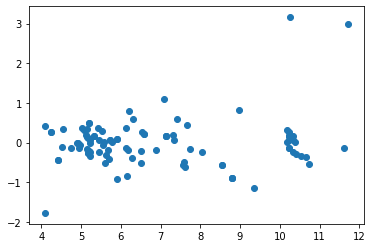

In [7]:
# 訓練データの残差プロット
import matplotlib.pyplot as plt
error_train = y_train - pred_train
plt.scatter(pred_train, error_train)
plt.show()

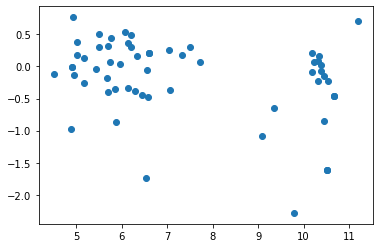

In [9]:
# テストデータの残差プロット
import matplotlib.pyplot as plt
error_test = y_test - pred_test
plt.scatter(pred_test, error_test)
plt.show()

**決定係数** : 訓練データとテストデータにおける決定係数を計算しておきます。

In [10]:
# 決定係数によるモデルの評価（訓練データ）
from sklearn.metrics import r2_score
r2_score(y_true = y_train, y_pred = pred_train)

0.9274891671111587

In [11]:
# 決定係数によるモデルの評価（テストデータ）
from sklearn.metrics import r2_score
r2_score(y_true = y_test, y_pred = pred_test)

0.9031236200264187

**学習曲線** : 横軸を繰り返し数、縦軸をその繰り返し時点でのモデルの損失の値にとったグラフを学習曲線といいます。ここで、instance `gbr`には`loss_` methodという損失の値を計算できるmethodと`train_score_`という各iterationにおける訓練データの損失をレコードしたinstance変数があることを知っておくと便利です。

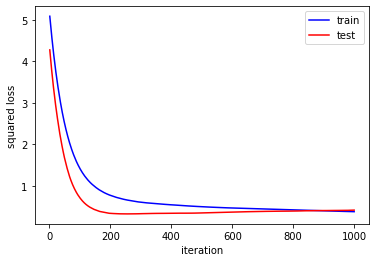

In [12]:
import numpy as np
# 学習曲線
max_iteration = 1000    # 設定したn_estimatorsの値
test_score = np.zeros(max_iteration, dtype=np.float64)

for i, pred_test in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y_test, pred_test)    # np.mean((y_test, pred_test)**2)と等しい。

#gbr.train_score_で訓練データでの損失を呼び出す
plt.plot(np.arange(max_iteration) + 1, gbr.train_score_, 'b-', label = "train")
plt.plot(np.arange(max_iteration) + 1, test_score, 'r-', label = "test")
plt.xlabel("iteration")
plt.ylabel("squared loss")
plt.legend()
plt.show()

### C. early stopping

**early stoppingの仕組み** : 学習曲線を見ると分かるように、`n_estimators`が大きくなると勾配ブースティング決定木回帰モデルは**過剰適合**する傾向にあることが知られています。そこで、early stoppingといって学習時に訓練データを学習に使うデータ（学習データ）と未知データに対する損失の値を監視するためのデータ（検証データ）に分割し、検証データにおける損失の値が上昇した時点で学習を打ち止める手法が一般的に採用されています。

[Remark] 検証データは勾配ブースティング法の計算自体には用いず、各iterationが終わるごとに得られた仮説の損失を計算し、監視するためだけに用います。

**`GradientBoostingRegressor`に対する設定** : `GradientBoostingRegressor` classは
* `n_iter_no_change` : 1時点前から`n_iter_no_change`時点前のすべてに対して、検証データにおける損失が現在よりも小さい場合、学習を打ち止める。
* `validation_fraction` : 訓練データのうちの何割を検証データとして分割するかを決める。

In [18]:
# 勾配ブースティング決定木回帰モデルの学習
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(learning_rate = 0.01,
                                n_estimators = 1000,
                                max_depth = None,    # max_depthを用いないための設定。
                                max_leaf_nodes = 4,
                                min_samples_leaf = 10,
                                n_iter_no_change = 5, 
                                validation_fraction = 0.2)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls',
                          max_depth=None, max_features=None, max_leaf_nodes=4,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=5, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.2, verbose=0, warm_start=False)

実際に、early stoppingつきで学習を行った結果、過剰適合を抑えることが出来ていることが分かります。

In [19]:
# 実際のiteration数
gbr.train_score_.shape

(361,)

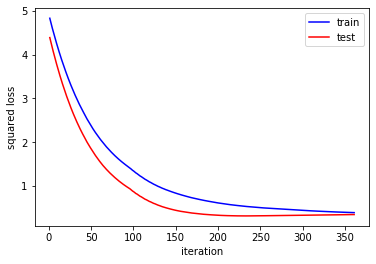

In [22]:
# 学習曲線
max_iteration = 361    # 確認した実際のiteration数
test_score = np.zeros(max_iteration, dtype=np.float64)

for i, pred_test in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y_test, pred_test) 

plt.plot(np.arange(max_iteration) + 1, gbr.train_score_, 'b-', label = "train")
plt.plot(np.arange(max_iteration) + 1, test_score, 'r-', label = "test")
plt.xlabel("iteration")
plt.ylabel("squared loss")
plt.legend()
plt.show()

### D. 変数重要度

勾配ブースティング決定木回帰モデルもまた決定木の他のアンサンブル学習と同様にして**変数重要度** (feature importance) を計算することが出来ます。以下の実装からも分かるように、各iterationで学習した決定木回帰の変数重要度について、入力変数ごとに平均をとり、合計が1になるように正規化したものを変数重要度と定義します。

<center><img src="./imgs/feature_importances_.png" width=500px></center>

[Remark] self.estimators_には、各iterationで学習した決定木回帰がlistで入っています。for文を走らせるとstageに1つずつ順番に決定木回帰が代入され、各列の（正規化された）変数重要度が足されていきます。今回`stage`の長さ`len(stage)`は1であることに注意してください。各列の変数重要度の総和を取ったら、その合計は決定木回帰の個数と一致するので、それで割ることで変数重要度を正規化しています。

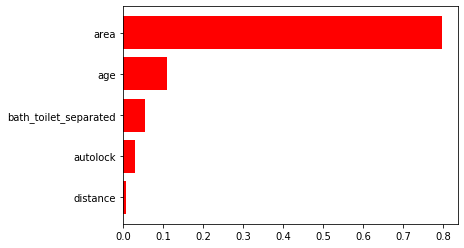

In [23]:
# 変数重要度
importances = gbr.feature_importances_
indices = np.argsort(importances)
plt.barh(np.asarray(feature_name)[indices], importances[indices],
         color="r", align="center")
plt.show()

In [24]:
importances

array([0.79679234, 0.11018435, 0.00673085, 0.05594551, 0.03034695])